<a href="https://colab.research.google.com/github/AjinthaSivam/Braille-to-English/blob/main/Braille_to_English.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU kagglehub

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shanks0465/braille-character-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.30M/1.30M [00:00<00:00, 131MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/shanks0465/braille-character-dataset/versions/1


In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from google.colab import files

In [5]:
def load_braille_dataset(dataset_path):
  images = []
  labels = []

  label_map = {}

  for i in range(26):
    letter = chr(97 + i)
    label_map[letter] = i

  print(label_map)

  label_reverse = {}

  for i in range(26):
    letter = chr(97 + i)
    label_reverse[i] = letter

  print(label_reverse)

  for img_name in os.listdir(dataset_path):
    if img_name.lower().endswith(('.jpg', 'jpeg')):
      img_path = os.path.join(dataset_path, img_name)
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      if img is not None:
        img = cv2.resize(img, (28, 28)) / 255.0
        images.append(img)

        char = img_name[0].lower()

        if char in label_map:
          label = label_map[char]
          labels.append(label)
        else:
          print(f"Unknown character: {char}")
      else:
        print(f"Failed to load image: {img_path}")
    else:
      print(f"Skipping non-image file: {img_name}")

  images = np.array(images).reshape(-1, 28, 28, 1)
  labels = np.array(labels)
  print(f"Total images loaded: {len(images)}, Total labels: {len(labels)}")
  return images, labels, label_reverse

In [6]:
dataset_path = os.path.join(path, "Braille Dataset/Braille Dataset")
images, labels, label_reverse = load_braille_dataset(dataset_path)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
Total images loaded: 1560, Total labels: 1560


In [8]:
# Function to create and train the CNN model
def create_and_train_model(X_train, y_train, X_val, y_val):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  # Increased units for better learning
        layers.Dropout(0.4),  # Add dropout to prevent overfitting
        layers.Dense(26, activation='softmax')  # a-z only
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),
                        batch_size=32)
    print(f"Training accuracy: {max(history.history['accuracy']):.4f}")
    print(f"Validation accuracy: {max(history.history['val_accuracy']):.4f}")
    return model

In [9]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create and train model
model = create_and_train_model(X_train, y_train, X_val, y_val)

# Save the model
model.save("braille_model.h5")
print("Model saved as braille_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.0401 - loss: 3.2678 - val_accuracy: 0.1250 - val_loss: 3.2504
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0667 - loss: 3.2096 - val_accuracy: 0.1987 - val_loss: 2.7729
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2333 - loss: 2.5437 - val_accuracy: 0.5321 - val_loss: 1.9105
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3841 - loss: 1.9269 - val_accuracy: 0.5737 - val_loss: 1.4989
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5677 - loss: 1.5112 - val_accuracy: 0.6571 - val_loss: 1.2247
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6385 - loss: 1.2255 - val_accuracy: 0.7147 - val_loss: 1.0415
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6785 - loss: 1.0383 - val_accuracy: 0.7308 - val_loss: 0.8901
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7252 - loss: 0.9053 - val_accuracy: 0.7532 - val_loss

Training accuracy: 0.9391
Validation accuracy: 0.9135
Model saved as braille_model.h5


Sample image shape: (1, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
Predicted character: j


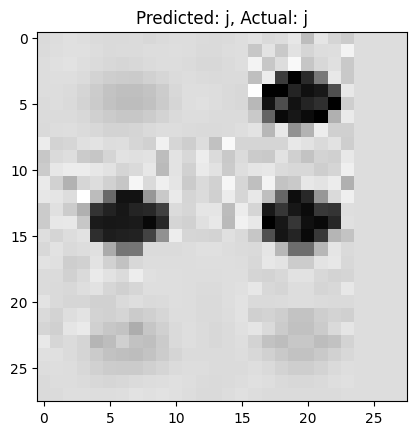

In [10]:
import matplotlib.pyplot as plt
# Test on a sample image
sample_image = X_val[4:5]  # Take first validation image
print(f"Sample image shape: {sample_image.shape}")
prediction = model.predict(sample_image)
predicted_label = np.argmax(prediction, axis=1)[0]
print(f"Predicted character: {label_reverse[predicted_label]}")
plt.imshow(sample_image[0].reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {label_reverse[predicted_label]}, Actual: {label_reverse[y_val[4]]}")
plt.show()

In [11]:
predictions = model.predict(X_val[0:20])
predicted_labels = np.argmax(predictions, axis=1)
print("Predicted:", [label_reverse[p] for p in predicted_labels])
print("Actual:", [label_reverse[a] for a in y_val[0:20]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
Predicted: ['g', 'a', 'f', 'r', 'j', 'l', 'a', 'x', 'v', 's', 'i', 'i', 'z', 'c', 'v', 'l', 'a', 'q', 'n', 'g']
Actual: ['g', 'a', 'f', 'r', 'j', 'l', 'a', 'x', 'v', 's', 'i', 'i', 'o', 'c', 'v', 'l', 'a', 'q', 'n', 'g']


In [12]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8981 - loss: 0.4031 
Validation accuracy: 0.9038
